# **Dicoding - Belajar Pengembangan Machine Learning**
# Submission 1 - NLP

Dataset:

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

import os
import zipfile

import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rakaputrawidyasf","key":"3d5ae91c469976eaffb6589099ee21a1"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d thomaskonstantin/highly-rated-children-books-and-stories

  0% 0.00/1.36M [00:00<?, ?B/s]
100% 1.36M/1.36M [00:00<00:00, 44.1MB/s]


In [6]:
zip_data = "highly-rated-children-books-and-stories.zip"
zip_ref = zipfile.ZipFile(zip_data, "r")
zip_ref.extractall()
zip_ref.close()

In [7]:
df = pd.read_csv("children_books.csv", engine="python")
df

,Title,Author,Desc,Inerest_age,Reading_age
0,The Girl Who Drank the Moon,Kelly Barnhill,"Every year, the evil Protectorate offers a bab...",10-14,10-14
1,Time Between Us,Tamara Ireland Stone,Sixteen-year-old Anna is struggling to underst...,13+,12+
2,Girl Out of Water,Nat Luurtsema,Lou Brown's swimming ambitions sank without tr...,13-18,10+
3,Captive,A J Grainger,Robyn is scared. Ever since the attempted assa...,13+,13
4,The School of Music,Rachel Bowen and Meurig Bowen Illustrator: Dan...,Welcome to the School of Music. In charge is M...,10+,10+
...,...,...,...,...,...
3264,Spy for the Queen of Scots,Theresa Breslin,"Beautiful young aristocrat Ginette, known as J...",12+,12+
3265,Jimmy Corrigan:,Chris Ware,This extraordinary graphic novel is so obvious...,14+,14+
3266,The Martian Girl,NaN,"Following on from the brilliant Lost on Mars, ...",10+,10+
3267,Buffalo Soldier,Tanya Landman,Plantation slave Charley Smith is eleven when ...,13+,11+


In [8]:
list(df.columns)

['Title', 'Author', 'Desc', 'Inerest_age', 'Reading_age']

Classify "Desc" contents by "Reading_age" categories

In [9]:
df.Reading_age.value_counts()

12+                                     708
13+                                     533
10+                                     525
11+                                     448
9+                                      352
8+                                      267
14+                                     173
10-14                                    91
13                                       87
10-12                                    85
Name: Reading_age, dtype: int64

In [10]:
reading_age = pd.get_dummies(df.Reading_age.str.strip())
df_new = pd.concat([df, reading_age], axis=1)
df_new = df_new.drop(columns=["Title", "Author", "Inerest_age", "Reading_age"])
df_new

,Desc,10+,10-12,10-14,11+,12+,13,13+,14+,8+,9+
0,"Every year, the evil Protectorate offers a bab...",0,0,1,0,0,0,0,0,0,0
1,Sixteen-year-old Anna is struggling to underst...,0,0,0,0,1,0,0,0,0,0
2,Lou Brown's swimming ambitions sank without tr...,1,0,0,0,0,0,0,0,0,0
3,Robyn is scared. Ever since the attempted assa...,0,0,0,0,0,1,0,0,0,0
4,Welcome to the School of Music. In charge is M...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
3264,"Beautiful young aristocrat Ginette, known as J...",0,0,0,0,1,0,0,0,0,0
3265,This extraordinary graphic novel is so obvious...,0,0,0,0,0,0,0,1,0,0
3266,"Following on from the brilliant Lost on Mars, ...",1,0,0,0,0,0,0,0,0,0
3267,Plantation slave Charley Smith is eleven when ...,0,0,0,1,0,0,0,0,0,0


In [11]:
list(df_new.columns)

['Desc', '10+', '10-12', '10-14', '11+', '12+', '13', '13+', '14+', '8+', '9+']

In [12]:
# X for "Tweet" values
# y for labels

X = df_new["Desc"].values
y = df_new[["10+", "10-12", "10-14", "11+", "12+", "13", "13+", "14+", "8+", "9+"]].values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
tokenizer = Tokenizer(num_words=5000, oov_token="x")
#tokenizer = Tokenizer(num_words=5000, oov_token="x",
                      #filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(train_sequences)
padded_test = pad_sequences(test_sequences)

In [15]:
model = keras.Sequential([
    keras.layers.Embedding(input_dim=5000, output_dim=64),
    keras.layers.LSTM(64),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 355,802
Trainable params: 355,802
Non-trainable params: 0
_________________________________________________________________


In [17]:
class CallBack(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("accuracy")>=0.950):
      print("Accuracy was >= 95%. Stop training...")
      self.model.stop_training = True

callbacks = CallBack()

In [18]:
epochs = 10
history = model.fit(padded_train, y_train,
                    epochs=epochs,
                    validation_data=(padded_test, y_test),
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/10
82/82 - 32s - loss: 1.5667 - accuracy: 0.4402 - val_loss: 0.7827 - val_accuracy: 0.8502
Epoch 2/10
82/82 - 29s - loss: 0.4002 - accuracy: 0.8937 - val_loss: 0.1797 - val_accuracy: 0.9985
Epoch 3/10
82/82 - 29s - loss: 0.0555 - accuracy: 0.9989 - val_loss: 0.0156 - val_accuracy: 0.9985
Accuracy was >= 95%. Stop training...


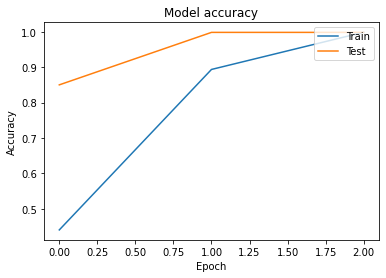

In [19]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper right")
plt.show()

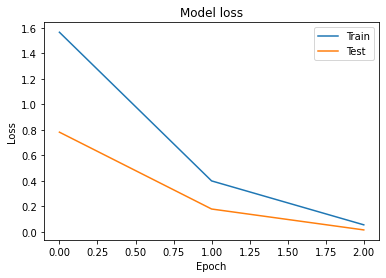

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper right")
plt.show()